# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

E:\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [43]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY Time
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [44]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
This is a very good bar. There are lots of nuts and different kinds of fruit, but there is a bit too much sweetener (honey, etc). Good for breakfast, or half of one as a snack to get me through to lunch/dinner.<br /><br />Great price! Cheaper than Kind bars, although not as many different kinds available.
Taylor's of Hargate Irish Breakfast tea is the only way to start you day.  The flavor is robust without being overdone and offers the little caffine kick I know I need to jump-start my morning.  Taylor's Tea also is lovely in the afternoon with a little sweet something.  Fine tea.
Great flavor and love the snap!  When your lookin

In [14]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [15]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
This is a very good bar. There are lots of nuts and different kinds of fruit, but there is a bit too much sweetener (honey, etc). Good for breakfast, or half of one as a snack to get me through to lunch/dinner.Great price! Cheaper than Kind bars, although not as many different kinds available.
Taylor's of Hargate Irish Breakfast tea is the only way to start you day.  The flavor is robust without being overdone and offers the little caffine kick I know I need to jump-start my morning.  Taylor's Tea also is lovely in the afternoon with a little sweet something.  Fine tea.
Great flavor and love the snap!  When your looking for something crunch

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Taylor is of Hargate Irish Breakfast tea is the only way to start you day.  The flavor is robust without being overdone and offers the little caffine kick I know I need to jump-start my morning.  Taylor is Tea also is lovely in the afternoon with a little sweet something.  Fine tea.


In [18]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [19]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Taylor is of Hargate Irish Breakfast tea is the only way to start you day The flavor is robust without being overdone and offers the little caffine kick I know I need to jump start my morning Taylor is Tea also is lovely in the afternoon with a little sweet something Fine tea 


In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████| 87773/87773 [00:35<00:00, 2499.80it/s]


In [22]:
preprocessed_reviews[0]

'bought apartment infested fruit flies hours trap attracted many flies within days practically gone may not long term solution flies driving crazy consider buying one caution surface sticky try avoid touching'

In [23]:
x_train=preprocessed_reviews[0:60000]
x_cv=preprocessed_reviews[60000:73000]
x_test=preprocessed_reviews[73000:87772]

#type(x_test)
y=final['Score'].values
y_train=y[0:60000]
y_cv=y[60000:73000]
y_test=y[73000:87772]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(x_train)
X_train_bow = count_vect.transform(x_train)
X_cv_bow = count_vect.transform(x_cv)
X_test_bow = count_vect.transform(x_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(60000, 45255) (60000,)
(13000, 45255) (13000,)
(14772, 45255) (14772,)


## [4.2] Bi-Grams and n-Grams.

## [4.3] TF-IDF

In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(x_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(x_train)
X_train_tfidf = tf_idf_vect.transform(x_train)
X_cv_tfidf = tf_idf_vect.transform(x_cv)
X_test_tfidf = tf_idf_vect.transform(x_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)


some sample features(unique words in the corpus) ['aa', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew']
After vectorizations
(60000, 35268) (60000,)
(13000, 35268) (13000,)
(14772, 35268) (14772,)


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [27]:
# Please write all the code with proper documentation
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

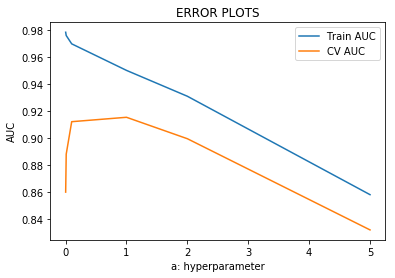

In [28]:
train_auc = []
cv_auc = []
a = [10**(-3),10**(-2),10**(-1),1,2,5]
for i in a:
    neigh = MultinomialNB(alpha=i, fit_prior=True, class_prior=[0.5,0.5])
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(a, train_auc, label='Train AUC')
plt.plot(a, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



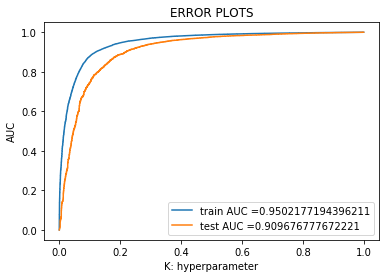

Train confusion matrix
[[ 7765  1627]
 [ 3383 47225]]
Test confusion matrix
[[ 1806   650]
 [  912 11404]]


In [47]:
from sklearn.metrics import roc_curve, auc

#From the above graph it is clear that alpha=1 gives a good result
neigh = MultinomialNB(alpha=1, fit_prior=True, class_prior=[0.5,0.5])
neigh.fit(X_train_bow, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))


Text(91.68, 0.5, 'predicted label')

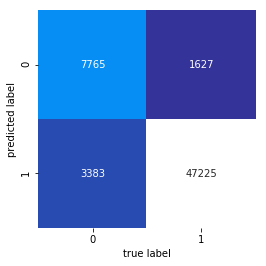

In [48]:
#Heatmap of train  data
#Resource:https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap

train_confm=(confusion_matrix(y_train, neigh.predict(X_train_bow)))
sns.heatmap(train_confm,annot=True,square=True,cbar=False,fmt="d",cmap='terrain')
plt.xlabel("true label")
plt.ylabel("predicted label")


Text(91.68, 0.5, 'predicted label')

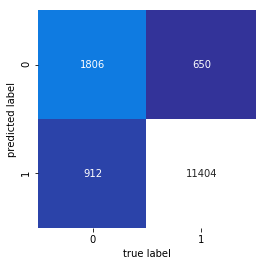

In [49]:
#Heatmap
#Resource:https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap

confm=(confusion_matrix(y_test, neigh.predict(X_test_bow)))
sns.heatmap(confm,annot=True,square=True,cbar=False,fmt="d",cmap='terrain')
plt.xlabel("true label")
plt.ylabel("predicted label")


In [55]:
#Accuracy using the the confusion matrix
(1806+11404)/(1806+11404+912+650)

0.8942594096940157

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [33]:
#Resource:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers/11140887#11140887
class_labels = neigh.classes_
feature_names = count_vect.get_feature_names()
topn_class2 = sorted(zip(neigh.feature_count_[1], feature_names),reverse=True)[:10]

print("Important words in positive reviews")

for coef, feat in topn_class2:
    print(class_labels[1], coef, feat)

Important words in positive reviews
1 47126.0 not
1 20871.0 like
1 18331.0 good
1 16924.0 great
1 14874.0 one
1 13255.0 taste
1 12188.0 tea
1 12097.0 would
1 11984.0 flavor
1 11954.0 love


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [34]:
class_labels = neigh.classes_
feature_names = count_vect.get_feature_names()
topn_class1 = sorted(zip(neigh.feature_count_[0], feature_names),reverse=True)[:10]

print("Important words in negative reviews")
for coef, feat in topn_class1:
    print(class_labels[0], coef, feat)


Important words in negative reviews
0 15319.0 not
0 5121.0 like
0 3977.0 would
0 3809.0 taste
0 3661.0 product
0 3204.0 one
0 2483.0 good
0 2468.0 coffee
0 2322.0 flavor
0 2316.0 no


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

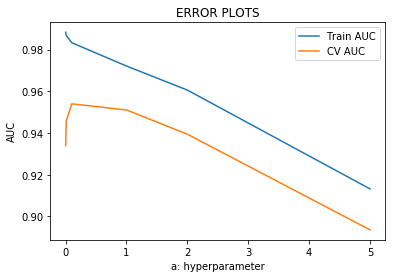

In [50]:
train_auc = []
cv_auc = []
a = [10**(-3),10**(-2),10**(-1),1,2,5]
for i in a:
    neigh = MultinomialNB(alpha=i, fit_prior=True, class_prior=[0.5,0.5])

    neigh.fit(X_train_tfidf, y_train)
    
    y_train_pred =  neigh.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(a, train_auc, label='Train AUC')
plt.plot(a, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

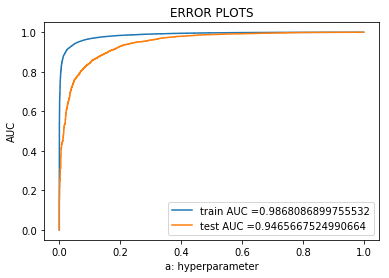

Train confusion matrix
[[ 8973   419]
 [ 3316 47292]]
Test confusion matrix
[[ 1991   465]
 [  985 11331]]


In [51]:
#From the above graph it is clear that alpha=0.01 gives a good result

neigh = MultinomialNB(alpha=0.01, fit_prior=True, class_prior=[0.5,0.5])
neigh.fit(X_train_tfidf, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_tfidf)))

Text(91.68, 0.5, 'predicted label')

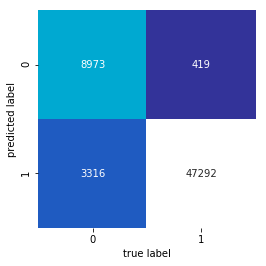

In [52]:
#Heatmap of train data
train_confm2=(confusion_matrix(y_train, neigh.predict(X_train_tfidf)))
sns.heatmap(train_confm2,annot=True,square=True,cbar=False,fmt="d",cmap='terrain')
plt.xlabel("true label")
plt.ylabel("predicted label")

Text(91.68, 0.5, 'predicted label')

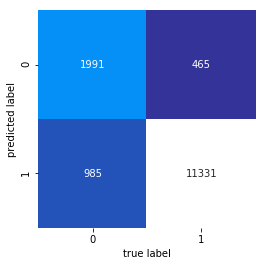

In [53]:
#Heatmap
confm2=confusion_matrix(y_test, neigh.predict(X_test_tfidf))
sns.heatmap(confm2,annot=True,square=True,cbar=False,fmt="d",cmap="terrain")
plt.xlabel("true label")
plt.ylabel("predicted label")

In [54]:
#Accuracy from the confusion matrix
(1991+11331)/(1991+11331+465+985)

0.9018413214189006

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [40]:
class_labels = neigh.classes_
feature_names = count_vect.get_feature_names()
topn_class1 = sorted(zip(neigh.feature_count_[1], feature_names),reverse=True)[:10]

print("Important words in positive reviews")
for coef, feat in topn_class1:
    print(class_labels[1], coef, feat)

Important words in positive reviews
1 1475.7605210499084 isleeve
1 1032.7288927628458 exceptionally
1 975.961156926444 enought
1 926.3487316005335 glutten
1 850.1653403932942 presto
1 830.0833267467445 camphor
1 809.2005358041577 hale
1 733.6946328759851 kneed
1 710.0133308125246 posh
1 700.1564134376235 medicine


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [41]:
class_labels = neigh.classes_
feature_names = count_vect.get_feature_names()
topn_class1 = sorted(zip(neigh.feature_count_[0], feature_names),reverse=True)[:10]

print("Important words in negative reviews")
for coef, feat in topn_class1:
    print(class_labels[0], coef, feat)

Important words in negative reviews
0 498.61991960890253 isleeve
0 226.05119102529255 glutten
0 199.38736256885753 posh
0 198.0658905320903 schooler
0 197.77109591549544 medicine
0 160.55887659931955 camphor
0 148.81993540090212 kneed
0 127.38324228715268 diarrheaalso
0 125.79007436320283 intollerant
0 117.56321321226467 enought


# [6] Conclusions

In [56]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names =['Vectorizer','Model','HyperParameter(Alpha)','AUC','Accuracy']
x.add_row(['BOW','Multinomial Naive Bayes',1,0.909,89.94])
x.add_row(['TFIDF','Multinomial Naive Bayes',0.01,0.946,90.18])
print(x)




+------------+-------------------------+-----------------------+-------+----------+
| Vectorizer |          Model          | HyperParameter(Alpha) |  AUC  | Accuracy |
+------------+-------------------------+-----------------------+-------+----------+
|    BOW     | Multinomial Naive Bayes |           1           | 0.909 |  89.94   |
|   TFIDF    | Multinomial Naive Bayes |          0.01         | 0.946 |  90.18   |
+------------+-------------------------+-----------------------+-------+----------+
